In [45]:
import os
import requests
from time import sleep

base_url = "https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/all/"

station_ids = [
    'CHM00050953',  # Harbin
    'CHM00054511',  # Beijing
    'CHM00057494',  # Wuhan
    'CHM00059287',  # Guangzhou
    'USW00014922',  # Minneapolis
    'USW00094846',  # Chicago
    'USW00013874',  # Atlanta
    'USW00012839',  # Miami
]

output_dir = "./ghcn_data"
os.makedirs(output_dir, exist_ok=True)

for station_id in station_ids:
    url = f"{base_url}{station_id}.dly"
    filename = os.path.join(output_dir, f"{station_id}.dly")

    if os.path.exists(filename):
        print(f"Already downloaded: {station_id}")
        continue

    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            with open(filename, "wb") as f:
                f.write(response.content)
            print(f"Downloaded: {station_id}")
        else:
            print(f"Failed: {station_id}, Status code: {response.status_code}")
    except Exception as e:
        print(f"Error downloading {station_id}: {e}")
    
    sleep(1) 

print("All downloads completed.")


Already downloaded: CHM00050953
Already downloaded: CHM00054511
Already downloaded: CHM00057494
Downloaded: CHM00059287
Already downloaded: USW00014922
Already downloaded: USW00094846
Already downloaded: USW00013874
Already downloaded: USW00012839
All downloads completed.


In [47]:
import os
os.listdir('./ghcn_data')


['USW00012839.dly',
 'CHM00045004.dly',
 'USW00013874.dly',
 'CHM00054511.dly',
 'USW00094846.dly',
 'USW00014922.dly',
 'CHM00050953.dly',
 'CHM00059287.dly',
 'CHM00057494.dly']

In [51]:
import pandas as pd
import os
import calendar

station_mapping = {
    'CHM00050953': 'Harbin',
    'CHM00054511': 'Beijing',
    'CHM00057494': 'Wuhan',
    'CHM00059287': 'Guangzhou',
    'USW00014922': 'Minneapolis',
    'USW00094846': 'Chicago',
    'USW00013874': 'Atlanta',
    'USW00012839': 'Miami'
}

uploaded_files = [
    './ghcn_data/CHM00050953.dly',
    './ghcn_data/CHM00054511.dly',
    './ghcn_data/CHM00057494.dly',
    './ghcn_data/CHM00059287.dly',
    './ghcn_data/USW00014922.dly',
    './ghcn_data/USW00094846.dly',
    './ghcn_data/USW00013874.dly',
    './ghcn_data/USW00012839.dly'
]


def parse_dly(file_path):
    records = []
    with open(file_path, 'r') as f:
        for line in f:
            station_id = line[0:11]
            year = int(line[11:15])
            month = int(line[15:17])
            element = line[17:21]
            max_day = calendar.monthrange(year, month)[1]  # 动态判断当月最大天数
            for day in range(1, 32):
                if day > max_day:
                    continue  # 跳过无效日期
                value_str = line[21 + (day - 1) * 8: 26 + (day - 1) * 8]
                if value_str.strip() == "-9999":
                    value = None
                else:
                    value = int(value_str) / 10
                date = pd.Timestamp(year=year, month=month, day=day)
                records.append((station_id, date, element, value))
    return pd.DataFrame(records, columns=["station", "date", "element", "value"])

# 解析并合并所有数据
all_data = pd.DataFrame()
for file in uploaded_files:
    df = parse_dly(file)
    all_data = pd.concat([all_data, df])

filtered_data = all_data[all_data['element'].isin(['TMAX', 'TMIN','PRCP'])].copy()

# 添加城市名称
filtered_data['city'] = filtered_data['station'].map(station_mapping)

all_data.head(120)

,station,date,element,value
0,CHM00050953,1951-01-01,TMAX,-23.8
1,CHM00050953,1951-01-02,TMAX,-20.0
2,CHM00050953,1951-01-03,TMAX,-20.4
3,CHM00050953,1951-01-04,TMAX,-24.1
4,CHM00050953,1951-01-05,TMAX,-20.8
...,...,...,...,...
115,CHM00050953,1951-01-23,TAVG,-17.3
116,CHM00050953,1951-01-24,TAVG,-14.7
117,CHM00050953,1951-01-25,TAVG,-16.5
118,CHM00050953,1951-01-26,TAVG,-14.3


In [53]:
# 我们先将目前处理好的 daily-level 数据存储成 CSV
# 文件名可以叫 intermediate_full_daily.csv

filtered_data.to_csv("intermediate_full_daily.csv", index=False)

print("完整 daily 数据已存储为 CSV")


完整 daily 数据已存储为 CSV


In [99]:
import pandas as pd

# 读取 daily-level 数据
df = pd.read_csv("intermediate_full_daily.csv")
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

# 我们只取完整年的数据
df = df[(df['year'] >= 1960) & (df['year'] <= 2015)]


# 计算年度平均温度
tavg = df[df['element'].isin(['TMAX', 'TMIN'])].pivot_table(
    index=['city','year'],
    columns='element',
    values='value',
    aggfunc='mean'
).reset_index()
tavg['TAVG'] = (tavg['TMAX'] + tavg['TMIN']) / 2

# 计算极端最高温 (年内最高的 TMAX)
tmax_extreme = df[df['element'] == 'TMAX'].groupby(['city','year'])['value'].max().reset_index()
tmax_extreme.rename(columns={'value':'TMAX_EXTREME'}, inplace=True)

# 计算极端最低温 (年内最低的 TMIN)
tmin_extreme = df[df['element'] == 'TMIN'].groupby(['city','year'])['value'].min().reset_index()
tmin_extreme.rename(columns={'value':'TMIN_EXTREME'}, inplace=True)

# 计算年降水总量
prcp_sum = df[df['element'] == 'PRCP'].groupby(['city','year'])['value'].sum().reset_index()
prcp_sum.rename(columns={'value':'PRCP_SUM'}, inplace=True)

# 合并所有指标
annual = tavg.merge(tmax_extreme, on=['city','year']).merge(tmin_extreme, on=['city','year']).merge(prcp_sum, on=['city','year'])

# 保存最终版数据
annual.to_csv("annual_final.csv", index=False)

# 预览部分数据
annual.head(120)


,city,year,TMAX,TMIN,TAVG,TMAX_EXTREME,TMIN_EXTREME,PRCP_SUM
0,Atlanta,1960,21.401913,10.750273,16.076093,35.6,-12.2,1171.7
1,Atlanta,1961,21.155616,10.151233,15.653425,33.3,-12.2,1489.0
2,Atlanta,1962,21.415890,10.054795,15.735342,34.4,-17.2,1215.2
3,Atlanta,1963,20.941918,9.803288,15.372603,34.4,-19.4,1405.6
4,Atlanta,1964,21.159016,10.492350,15.825683,36.7,-10.0,1528.3
...,...,...,...,...,...,...,...,...
115,Chicago,1963,14.619726,2.315342,8.467534,35.0,-28.3,642.3
116,Chicago,1964,15.448087,3.285792,9.366940,35.6,-25.0,756.1
117,Chicago,1965,14.360822,3.481096,8.920959,34.4,-25.6,993.3
118,Chicago,1966,14.889041,3.039452,8.964247,36.1,-28.9,813.9


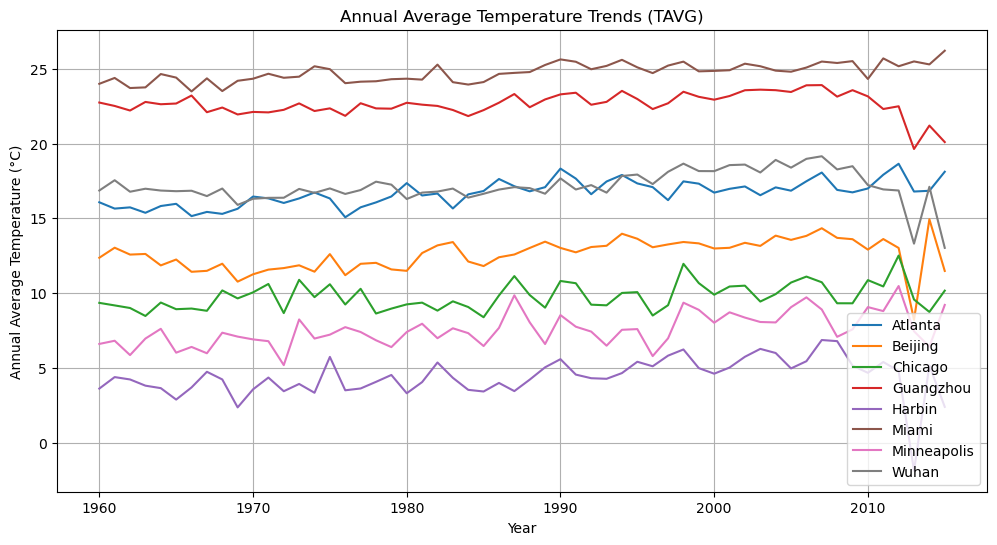

In [113]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取最终数据
df = pd.read_csv("annual_final.csv")

# 过滤掉不完整年份
df = df[df['year'] <= 2024]

# 作图
plt.figure(figsize=(12, 6))
for city in df['city'].unique():
    city_data = df[df['city'] == city]
    plt.plot(city_data['year'], city_data['TAVG'], label=city)

plt.xlabel("Year")
plt.ylabel("Annual Average Temperature (°C)")
plt.title("Annual Average Temperature Trends (TAVG)")
plt.legend()
plt.grid(True)
plt.savefig('./Annual Average Temperature Trends (TAVG).png', dpi=300, bbox_inches='tight')
plt.show()


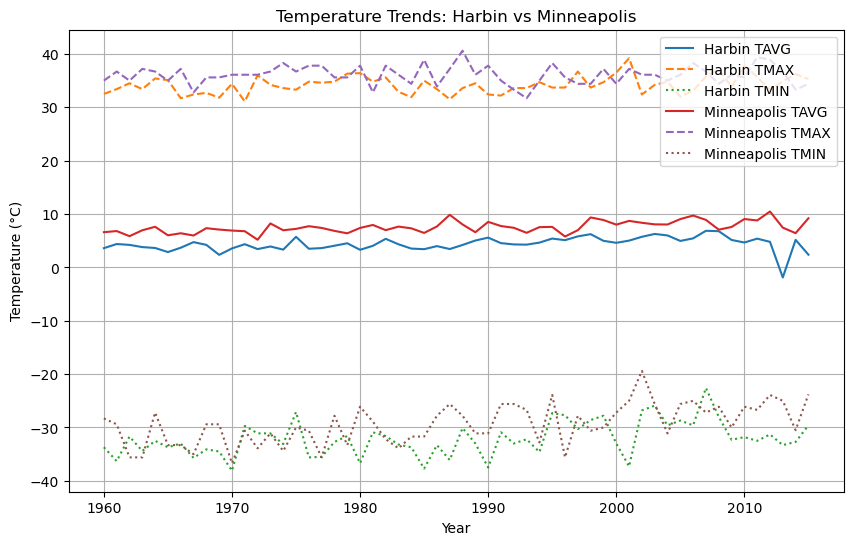

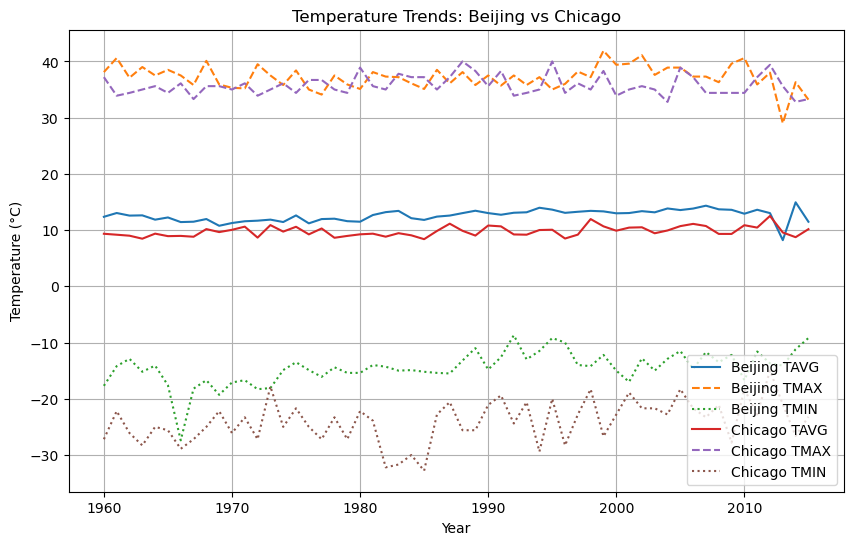

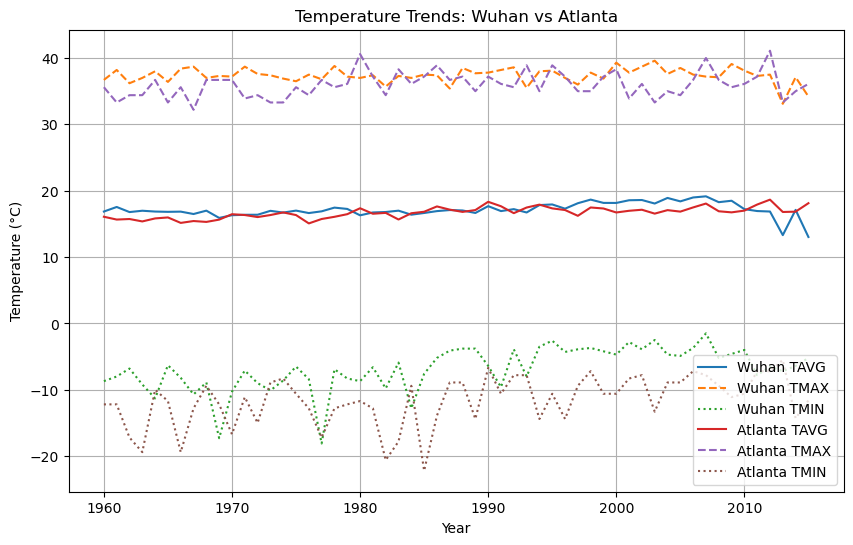

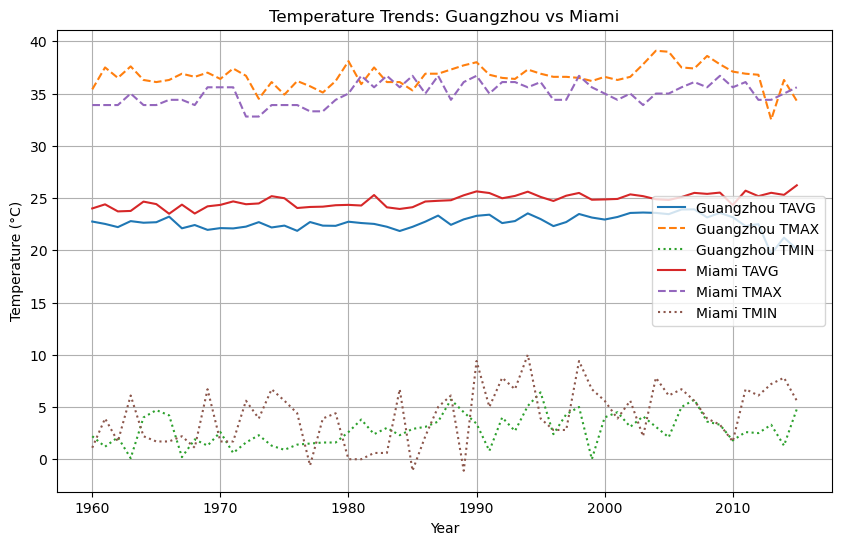

In [117]:
import matplotlib.pyplot as plt

# 先定义你的分组配对
group_pairs = [
    ('Harbin', 'Minneapolis'),
    ('Beijing', 'Chicago'),
    ('Wuhan', 'Atlanta'),
    ('Guangzhou', 'Miami')
]

# 依次作图
for china_city, us_city in group_pairs:
    plt.figure(figsize=(10,6))

    for city in [china_city, us_city]:
        sub = df[df['city']==city]
        plt.plot(sub['year'], sub['TAVG'], label=f"{city} TAVG")
        plt.plot(sub['year'], sub['TMAX_EXTREME'], linestyle='--', label=f"{city} TMAX")
        plt.plot(sub['year'], sub['TMIN_EXTREME'], linestyle=':', label=f"{city} TMIN")

    plt.title(f"Temperature Trends: {china_city} vs {us_city}")
    plt.xlabel("Year")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.grid()
    plt.savefig(f'./Temperature_Trends_{china_city}_vs_{us_city}.png', dpi=300, bbox_inches='tight')
    plt.show()


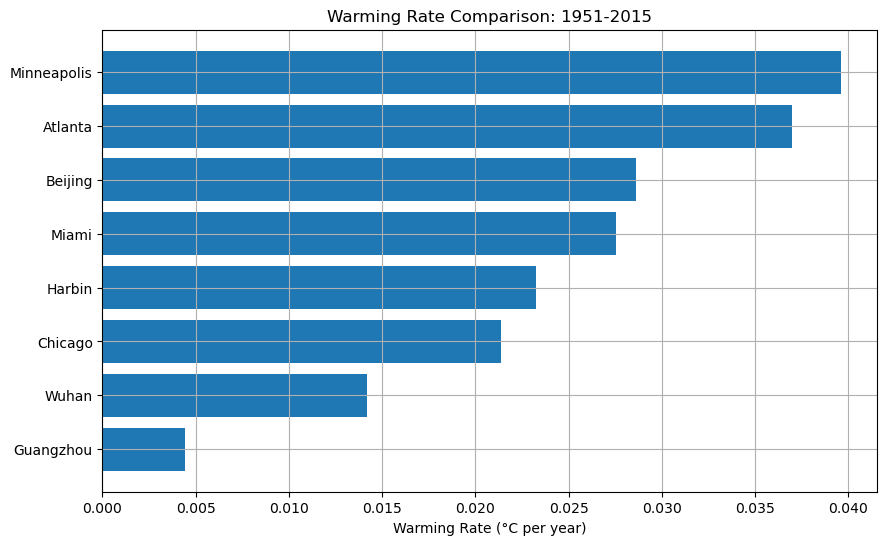

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

slope_results = {}

for city in df['city'].unique():
    sub = df[df['city'] == city]
    X = sub['year'].values.reshape(-1, 1)
    y = sub['TAVG'].values
    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]  # 每年升温斜率
    slope_results[city] = slope

# 排序后画柱状图
sorted_cities = sorted(slope_results, key=slope_results.get)
sorted_slopes = [slope_results[city] for city in sorted_cities]

plt.figure(figsize=(10,6))
plt.barh(sorted_cities, sorted_slopes)
plt.xlabel("Warming Rate (°C per year)")
plt.title("Warming Rate Comparison: 1951-2015")
plt.grid(True)
plt.savefig('./Warming Rate Comparison: 1951-2015', dpi=300, bbox_inches='tight')
plt.show()


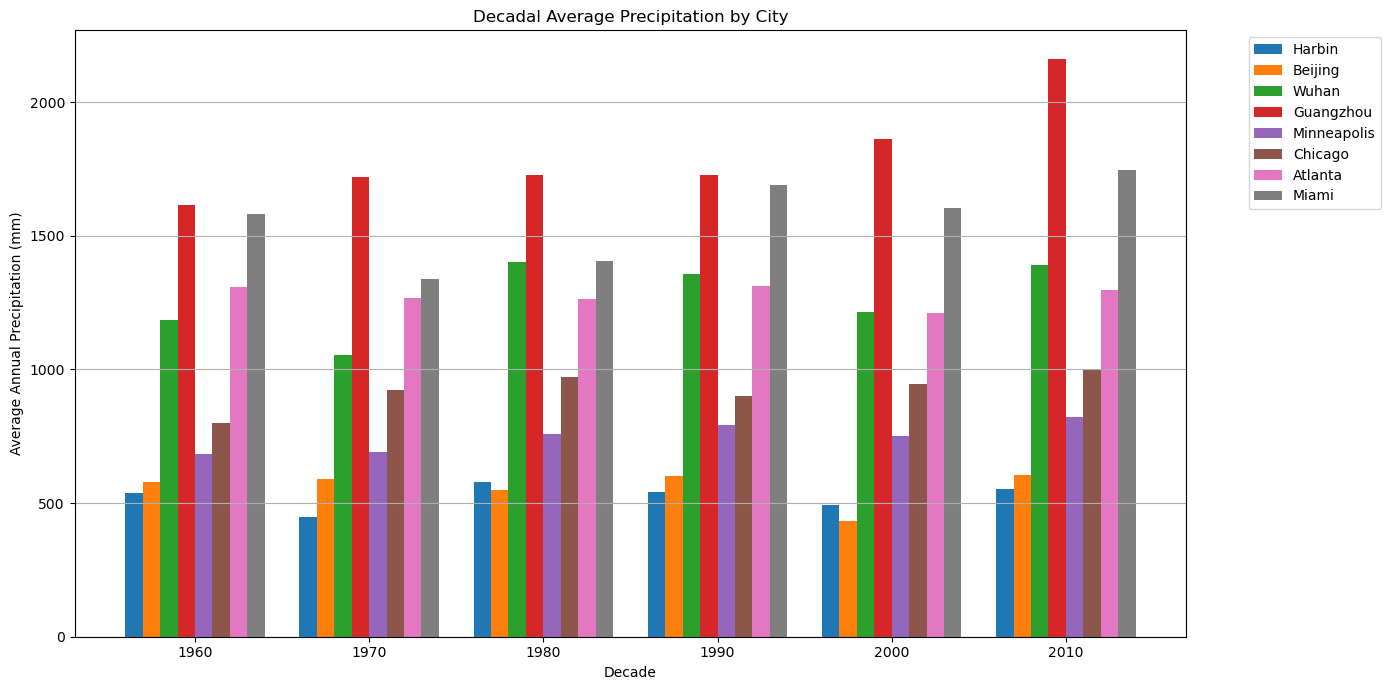

In [123]:
import numpy as np
import matplotlib.pyplot as plt

# 仍用之前已经做好的 prcp_decade 数据

decades = sorted(prcp_decade['decade'].unique())
cities = ['Harbin', 'Beijing', 'Wuhan', 'Guangzhou', 'Minneapolis', 'Chicago', 'Atlanta', 'Miami']

bar_width = 0.1
x = np.arange(len(decades))

plt.figure(figsize=(14, 7))

for i, city in enumerate(cities):
    sub = prcp_decade[prcp_decade['city'] == city]
    # 确保 decade 顺序对齐
    sub = sub.set_index('decade').reindex(decades).reset_index()
    plt.bar(x + i*bar_width, sub['PRCP_SUM'], width=bar_width, label=city)

plt.xticks(x + bar_width*3.5, decades)
plt.xlabel("Decade")
plt.ylabel("Average Annual Precipitation (mm)")
plt.title("Decadal Average Precipitation by City")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # 外置legend，避免遮挡
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('./Decadal_Precipitation_BarChart.png', dpi=300, bbox_inches='tight')
plt.show()
